## Using an external sample of stellar ages to calibrate the age-action relation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

import zoomies

%load_ext autoreload
%autoreload 2

# Stokholm RGB Sample

Read in data and calculate actions

In [2]:
# Reading calibration sample of RGB stars with ages, crossmatched with Gaia
# Table from Stokholm et al. 2023 https://ui.adsabs.harvard.edu/abs/2023MNRAS.524.1634S/abstract
xmatch = Table.read('../../StokholmRGB_GaiaXmatch.csv')

# No negative parallaxes
xmatch = xmatch[xmatch['parallax'] > 0]

# Calculate actions for calibration stars and save
# This step will take a while for large samples
zoomies.calc_jz(xmatch, fname='../../StokholmRGB_GaiaXmatch_WithJz.fits')

MW 2022
/Users/ssagear/opt/anaconda3/envs/mdwarf/lib/python3.11/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

/Users/ssagear/opt/anaconda3/envs/mdwarf/lib/python3.11/site-packages/astropy/units/quantity.py:1823: RuntimeWarning: Mean of empty slice
  return super().__array_function__(function, types, args, kwargs)



TMASS_ID,KIC_ID,EPIC_ID,SOURCE_ID_GAIA,LABEL,SPECTROSURVEY,COMPONENT,PHASE,DNU,ERROR_DNU,ERROR_UNCORRECTED_DNU,NUMAX,ERROR_NUMAX,ERROR_UNCORRECTED_NUMAX,JMAG_TMASS,ERROR_JMAG_TMASS,HMAG_TMASS,ERROR_HMAG_TMASS,KMAG_TMASS,ERROR_KMAG_TMASS,TEFF,ERROR_TEFF,ERROR_UNCORRECTED_TEFF,M_H,ERROR_M_H,ERROR_UNCORRECTED_M_H,ALPHA_FE,ERROR_ALPHA_FE,RA_GAIA,ERROR_RA_GAIA,DEC_GAIA,ERROR_DEC_GAIA,PMRA_GAIA,ERROR_PMRA_GAIA,ERROR_PMRA_UNCORRECTED_GAIA,PMDEC_GAIA,ERROR_PMDEC_GAIA,ERROR_PMDEC_UNCORRECTED_GAIA,PARALLAX_GAIA,ERROR_PARALLAX_GAIA,UNCORRECTED_PARALLAX_GAIA,ERROR_PARALLAX_UNCORRECTED_GAIA,DNU_PROB_NEW,QFLG_TMASS,CHI2RATIO_LAMOST,TEFF_FLAG_LAMOST,LOGG_FLAG_LAMOST,VMIC_FLAG_LAMOST,MG_FE_FLAG_LAMOST,SI_FE_FLAG_LAMOST,FE_H_FLAG_LAMOST,FLAG_SINGLESTAR_LAMOST,STARFLAG_APOGEE,ASPCAPFLAG_APOGEE,FLAG_SP_GALAH,FLAG_FE_H_GALAH,FLAG_MG_FE_GALAH,FLAG_SI_FE_GALAH,ASTROMETRIC_PARAMS_SOLVED_GAIA,AGE_BASTA,LOWER_ERROR_AGE_BASTA,UPPER_ERROR_AGE_BASTA,LPHOT_BASTA,LOWER_ERROR_LPHOT_BASTA,UPPER_ERROR_LPHOT_BASTA,MASSFIN_BASTA,LOWER_ERROR_MASSFIN_BASTA,UPPER_ERROR_MASSFIN_BASTA,RADIUS_BASTA,LOWER_ERROR_RADIUS_BASTA,UPPER_ERROR_RADIUS_BASTA,LOGG_BASTA,LOWER_ERROR_LOGG_BASTA,UPPER_ERROR_LOGG_BASTA,TEFF_BASTA,LOWER_ERROR_TEFF_BASTA,UPPER_ERROR_TEFF_BASTA,FE_H_BASTA,LOWER_ERROR_FE_H_BASTA,UPPER_ERROR_FE_H_BASTA,ME_H_BASTA,LOWER_ERROR_ME_H_BASTA,UPPER_ERROR_ME_H_BASTA,DNUSER_BASTA,LOWER_ERROR_DNUSER_BASTA,UPPER_ERROR_DNUSER_BASTA,NUMAX_BASTA,LOWER_ERROR_NUMAX_BASTA,UPPER_ERROR_NUMAX_BASTA,DISTANCE_BASTA,LOWER_ERROR_DISTANCE_BASTA,UPPER_ERROR_DISTANCE_BASTA,XINI_BASTA,LOWER_ERROR_XINI_BASTA,UPPER_ERROR_XINI_BASTA,YINI_BASTA,LOWER_ERROR_YINI_BASTA,UPPER_ERROR_YINI_BASTA,ZINI_BASTA,LOWER_ERROR_ZINI_BASTA,UPPER_ERROR_ZINI_BASTA,XRECT_GC,LOWER_ERROR_XRECT_GC,UPPER_ERROR_XRECT_GC,YRECT_GC,LOWER_ERROR_YRECT_GC,UPPER_ERROR_YRECT_GC,ZRECT_GC,LOWER_ERROR_ZRECT_GC,UPPER_ERROR_ZRECT_GC,U_HC,LOWER_ERROR_U_HC,UPPER_ERROR_U_HC,V_HC,LOWER_ERROR_V_HC,UPPER_ERROR_V_HC,W_HC,LOWER_ERROR_W_HC,UPPER_ERROR_W_HC,R_GC,LOWER_ERROR_R_GC,UPPER_ERROR_R_GC,PHI_GC,LOWER_ERROR_PHI_GC,UPPER_ERROR_PHI_GC,Z_GC,LOWER_ERROR_Z_GC,UPPER_ERROR_Z_GC,VR_GC,LOWER_ERROR_VR_GC,UPPER_ERROR_VR_GC,VPHI_GC,LOWER_ERROR_VPHI_GC,UPPER_ERROR_VPHI_GC,VZ_GC,LOWER_ERROR_VZ_GC,UPPER_ERROR_VZ_GC,JR,LOWER_ERROR_JR,UPPER_ERROR_JR,LZ,LOWER_ERROR_LZ,UPPER_ERROR_LZ,JZ,LOWER_ERROR_JZ,UPPER_ERROR_JZ,THETA_R,LOWER_ERROR_THETA_R,UPPER_ERROR_THETA_R,THETA_PHI,LOWER_ERROR_THETA_PHI,UPPER_ERROR_THETA_PHI,THETA_Z,LOWER_ERROR_THETA_Z,UPPER_ERROR_THETA_Z,ECCENTRICITY,LOWER_ERROR_ECCENTRICITY,UPPER_ERROR_ECCENTRICITY,ZMAX,LOWER_ERROR_ZMAX,UPPER_ERROR_ZMAX,RPERI,LOWER_ERROR_RPERI,UPPER_ERROR_RPERI,RAP,LOWER_ERROR_RAP,UPPER_ERROR_RAP,ENERGY,source_id,random_index,ra,dec,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_params_solved,pseudocolour,pseudocolour_error,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_expected_sig_to_noise,rv_renormalised_gof,rv_chisq_pvalue,phot_variable_flag,l,b,in_qso_candidates,in_galaxy_candidates,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,in_andromeda_survey,teff_gspphot,logg_gspphot,mh_gspphot,distance_gspphot,ag_gspphot,ebpminrp_gspphot,Jz,Jphi,Jr
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km kpc / s,km kpc / s,km kpc / s
str17,float64,float64,int64,str7,str6,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float

In [3]:
# Read table back in
xmatch = Table.read('../../StokholmRGB_GaiaXmatch_WithJz.fits')

# We exclude stars with very large Jzs -- usually this means something is off with the radial velocity data (?)
xmatch = xmatch[np.log(xmatch['Jz']) < 20]

In [4]:
# Putting age in Gyr, removing masks
age_nomask = np.array(xmatch['AGE_BASTA'])/1000
Jz_nomask = np.array(xmatch['Jz'])
age_err_nomask = np.array(np.nanmean((xmatch['LOWER_ERROR_AGE_BASTA']/1000, xmatch['UPPER_ERROR_AGE_BASTA']/1000), axis=0))

mask = age_err_nomask > 0

age = np.array(age_nomask[mask])
lnJz = np.array(np.log(Jz_nomask[mask]))
age_err = np.array(age_err_nomask[mask])

assert np.all(np.isfinite(age_err))
assert np.all(age_err > 0)

Text(0, 0.5, 'Age (Gyr)')

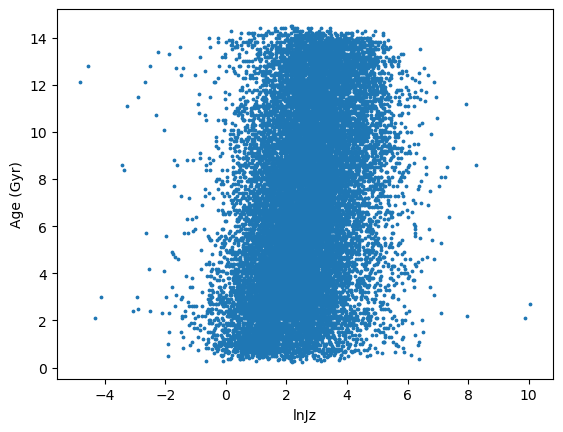

In [5]:
# Calibration sample in age-lnJz space
plt.scatter(lnJz,age, s=3)
plt.xlabel('lnJz')
plt.ylabel('Age (Gyr)')

### Calibrating the monotonic age-lnJz spline model

In [6]:
spline = zoomies.KinematicAgeSpline(lnJz, age, age_err)
spline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

And here's our spline model:

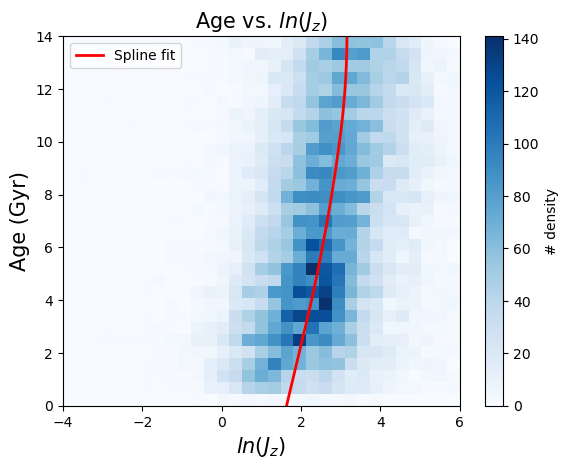

In [7]:
spline.plot_fit()

In [8]:
spline.write(directory='../../RGB_spline_model/')

In [9]:
newspline = zoomies.read(directory='../../RGB_spline_model/')

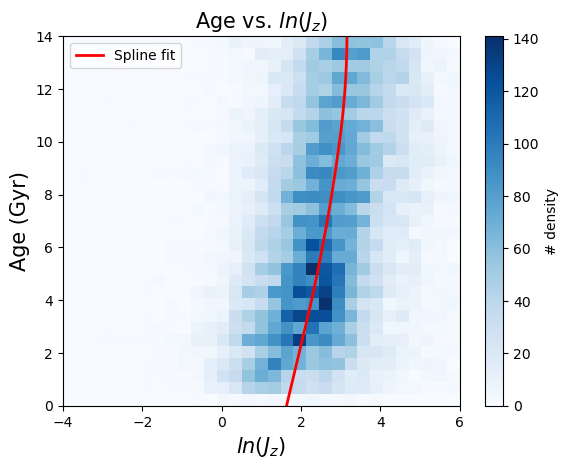

In [10]:
newspline.plot_fit()

In [11]:
eval_grid, eval_pdf_m3 = newspline.evaluate_ages(-3)
_, eval_pdf_m1 = newspline.evaluate_ages(-1)
_, eval_pdf_0 = newspline.evaluate_ages(0)
_, eval_pdf_1 = newspline.evaluate_ages(1)
_, eval_pdf_2 = newspline.evaluate_ages(2)
_, eval_pdf_3 = newspline.evaluate_ages(3)
_, eval_pdf_4 = newspline.evaluate_ages(4)
_, eval_pdf_5 = newspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

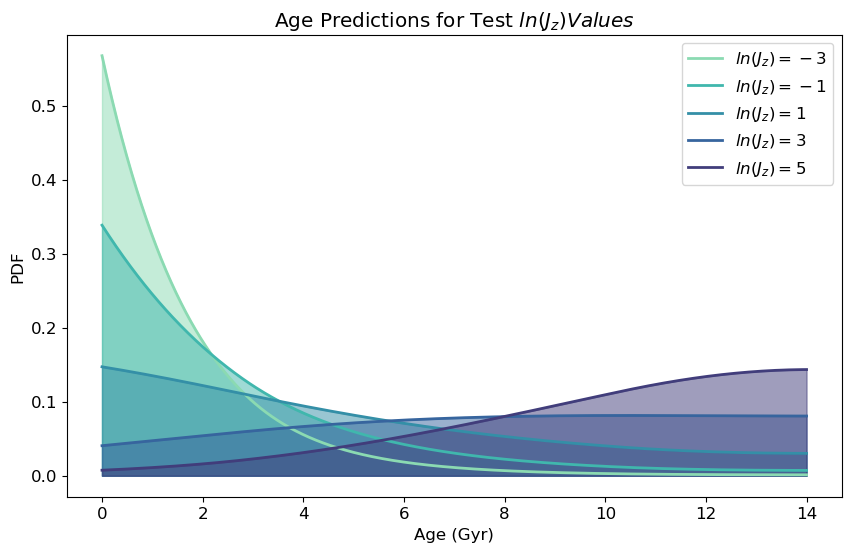

In [12]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, eval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for Test $ln(J_z) Values$')

In [13]:
kepler_ages = Table.read('../../Kepler_Age_Predictions.fits')
kep42 = float(np.log(kepler_ages[kepler_ages['kepid'] == 8561063]['Jz']))
kep125 = float(np.log(kepler_ages[kepler_ages['kepid'] == 10489206]['Jz']))
kep186 = float(np.log(kepler_ages[kepler_ages['kepid'] == 8120608]['Jz']))
kep249 = float(np.log(kepler_ages[kepler_ages['kepid'] == 7907423]['Jz']))
kep236 = float(np.log(kepler_ages[kepler_ages['kepid'] == 4725681]['Jz']))

/var/folders/fw/4y8lcb2j7b19v6vfzm__2nf80000gn/T/ipykernel_38539/973517122.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kep42 = float(np.log(kepler_ages[kepler_ages['kepid'] == 8561063]['Jz']))

/var/folders/fw/4y8lcb2j7b19v6vfzm__2nf80000gn/T/ipykernel_38539/973517122.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kep125 = float(np.log(kepler_ages[kepler_ages['kepid'] == 10489206]['Jz']))

/var/folders/fw/4y8lcb2j7b19v6vfzm__2nf80000gn/T/ipykernel_38539/973517122.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your arr

In [15]:
# kep42 = 3.6486240894109683
# kep125 = -0.9615162137394352
# kep186 = -1.657133801967237
# kep249 = 0.9103696829926338
# kep236 = -0.39834222813493686

Text(0.5, 1.0, 'Age Predictions for M Dwarf Planet Hosts')

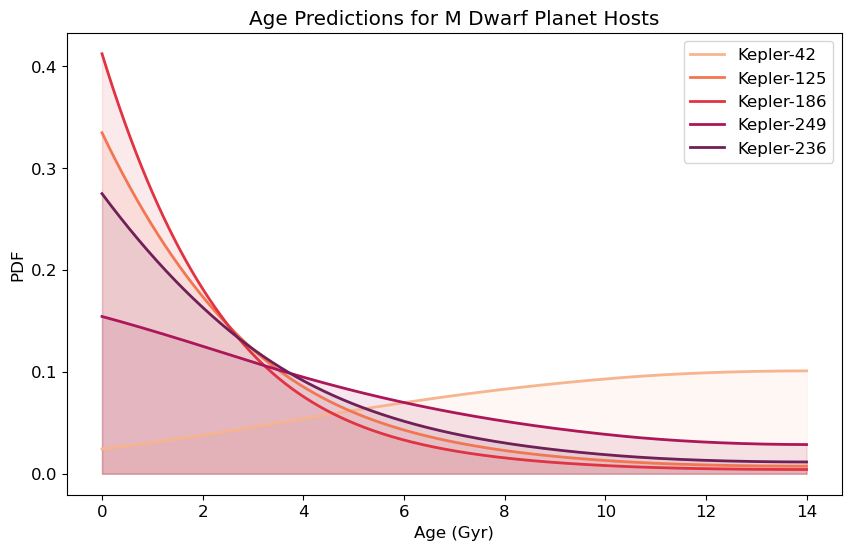

In [14]:
eval_grid, eval_pdf_kep42 = spline.evaluate_ages(kep42)
_, eval_pdf_kep125 = spline.evaluate_ages(kep125)
_, eval_pdf_kep186 = spline.evaluate_ages(kep186)
_, eval_pdf_kep249 = spline.evaluate_ages(kep249)
_, eval_pdf_kep236 = spline.evaluate_ages(kep236)


import seaborn as sns

plt.plot(eval_grid, eval_pdf_kep42, label='Kepler-42', color=sns.color_palette("rocket_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep125, label='Kepler-125', color=sns.color_palette("rocket_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep186, label='Kepler-186', color=sns.color_palette("rocket_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep249, label='Kepler-249', color=sns.color_palette("rocket_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_kep236, label='Kepler-236', color=sns.color_palette("rocket_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_kep42, 0, color=sns.color_palette("rocket_r").as_hex()[0], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep125, 0, color=sns.color_palette("rocket_r").as_hex()[1], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep186, 0, color=sns.color_palette("rocket_r").as_hex()[2], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep249, 0, color=sns.color_palette("rocket_r").as_hex()[3], alpha=0.1)
plt.fill_between(eval_grid, eval_pdf_kep236, 0, color=sns.color_palette("rocket_r").as_hex()[4], alpha=0.1)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for M Dwarf Planet Hosts')

# StarHorse APOGEE Sample

Read in data and calculate actions

In [15]:
starhorse_apogee = Table.read('../../../starhorse_data/StarHorse_APOGEE_composite.ecsv')
starhorse_apogee = starhorse_apogee[starhorse_apogee['StarHorse_AGE_INOUT'] != 'Warn_diff_inout']
starhorse_apogee = starhorse_apogee[starhorse_apogee['parallax'] > 0]

zoomies.calc_jz(starhorse_apogee, write=True, fname='../../StarHorse_APOGEE_composite_WithActions.fits')

MW 2022
/Users/ssagear/opt/anaconda3/envs/mdwarf/lib/python3.11/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



/Users/ssagear/opt/anaconda3/envs/mdwarf/lib/python3.11/site-packages/astropy/units/quantity.py:1823: RuntimeWarning: Mean of empty slice
  return super().__array_function__(function, types, args, kwargs)



In [16]:
xmatch = Table.read('../../StarHorse_APOGEE_composite_WithActions.fits')
xmatch = xmatch[xmatch['StarHorse_AGE_INOUT'] != 'Warn_diff_inout']
xmatch = xmatch[np.log(xmatch['Jz']) < 20]

In [17]:
age_nomask = np.array(xmatch['age50'])
Jz_nomask = np.array(xmatch['Jz'])
age_err_nomask = np.array(np.nanmean((xmatch['age50']-xmatch['age16'], xmatch['age84']-xmatch['age50']), axis=0))

mask = age_err_nomask > 0

age = np.array(age_nomask[mask])
lnJz = np.array(np.log(Jz_nomask[mask]))
age_err = np.array(age_err_nomask[mask])

assert np.all(np.isfinite(age_err))
assert np.all(age_err > 0)

Text(0.5, 1.0, 'MSTO Calibration Sample')

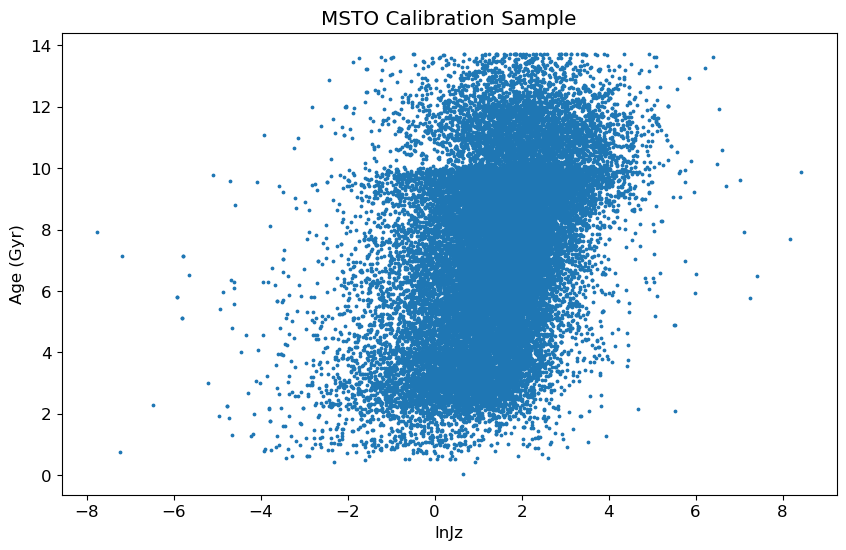

In [18]:
plt.scatter(lnJz, age, s=3)

plt.xlabel('lnJz')
plt.ylabel('Age (Gyr)')

plt.title('MSTO Calibration Sample')

Calibrate monotonic spline model

In [19]:
import jax.numpy as jnp
spline = zoomies.KinematicAgeSpline(jnp.array(lnJz), jnp.array(age), jnp.array(age_err))
spline.fit_mono_spline(num_warmup=2000, num_samples=2000)

Fitting line...


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

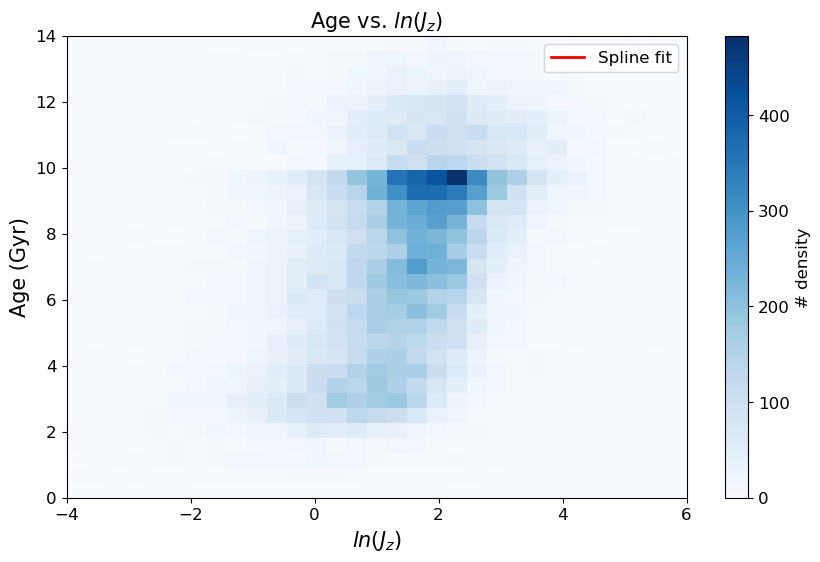

In [20]:
spline.plot_fit()

In [21]:
spline.write(directory='../../MSTO_spline_model/')

In [22]:
newspline = zoomies.read(directory='../../MSTO_spline_model/')

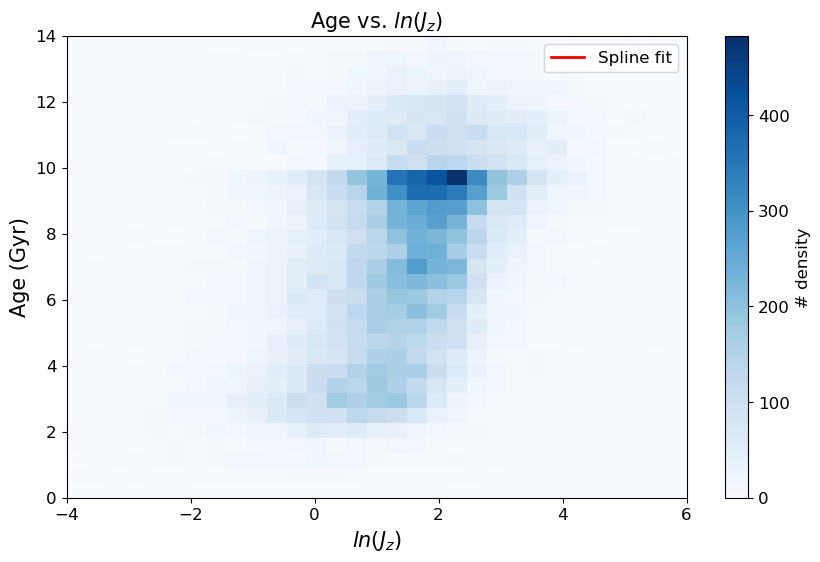

In [23]:
newspline.plot_fit()

In [24]:
eval_grid, eval_pdf_m3 = newspline.evaluate_ages(-3)
_, eval_pdf_m1 = newspline.evaluate_ages(-1)
_, eval_pdf_0 = newspline.evaluate_ages(0)
_, eval_pdf_1 = newspline.evaluate_ages(1)
_, eval_pdf_2 = newspline.evaluate_ages(2)
_, eval_pdf_3 = newspline.evaluate_ages(3)
_, eval_pdf_4 = newspline.evaluate_ages(4)
_, eval_pdf_5 = newspline.evaluate_ages(5)

Text(0.5, 1.0, 'Age Predictions for Test $ln(J_z) Values$')

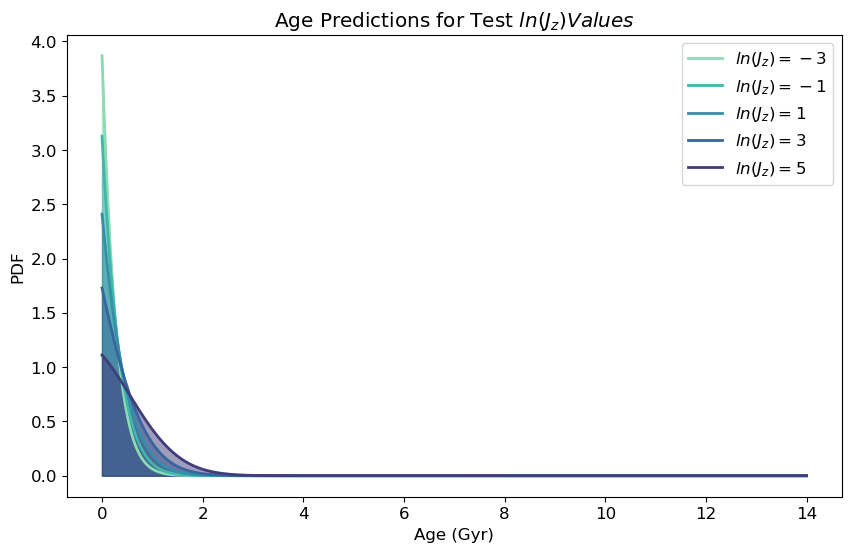

In [25]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

plt.plot(eval_grid, eval_pdf_m3, label='$ln(J_z)=-3$', color=sns.color_palette("mako_r").as_hex()[0], linewidth=2)
plt.plot(eval_grid, eval_pdf_m1, label='$ln(J_z)=-1$', color=sns.color_palette("mako_r").as_hex()[1], linewidth=2)
plt.plot(eval_grid, eval_pdf_1, label='$ln(J_z) = 1 $', color=sns.color_palette("mako_r").as_hex()[2], linewidth=2)
plt.plot(eval_grid, eval_pdf_3, label='$ln(J_z) = 3 $', color=sns.color_palette("mako_r").as_hex()[3], linewidth=2)
plt.plot(eval_grid, eval_pdf_5, label='$ln(J_z) = 5 $', color=sns.color_palette("mako_r").as_hex()[4], linewidth=2)

plt.fill_between(eval_grid, eval_pdf_m3, 0, color=sns.color_palette("mako_r").as_hex()[0], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_m1, 0, color=sns.color_palette("mako_r").as_hex()[1], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_1, 0, color=sns.color_palette("mako_r").as_hex()[2], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_3, 0, color=sns.color_palette("mako_r").as_hex()[3], alpha=.5)
plt.fill_between(eval_grid, eval_pdf_5, 0, color=sns.color_palette("mako_r").as_hex()[4], alpha=.5)

plt.legend()

plt.xlabel('Age (Gyr)')
plt.ylabel('PDF')

plt.title('Age Predictions for Test $ln(J_z) Values$')